In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Feature Engineering

In [2]:
def convert_char_to_num(c):
    return ord(c) - ord('a')

## Trainning set

In [3]:
df_X = pd.read_csv('xtrain_obfuscated.txt', header=None)
df_X.columns = ['Text']

df_y = pd.read_csv('ytrain.txt', header=None)
df_y.columns = ['Label']

df = df_X.join(df_y)
df.head()

,Text,Label
0,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...,7
1,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...,3
2,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...,8
3,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...,3
4,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...,4


In [4]:
df['Character vector'] = df['Text'].transform(lambda X: np.array([convert_char_to_num(c) for c in X]))
df.head()

,Text,Label,Character vector
0,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...,7,"[18, 0, 19, 22, 0, 12, 20, 11, 20, 7, 16, 6, 2..."
1,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...,3,"[19, 22, 12, 10, 8, 22, 15, 12, 16, 21, 19, 22..."
2,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...,8,"[21, 8, 3, 5, 15, 12, 18, 10, 20, 7, 21, 8, 11..."
3,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...,3,"[17, 0, 18, 10, 11, 4, 4, 13, 10, 17, 11, 17, ..."
4,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...,4,"[3, 5, 4, 13, 16, 21, 20, 7, 19, 22, 0, 12, 16..."


In [5]:
X_train, y_train = np.array(df['Character vector'].values), df['Label'].values

print(X_train.shape)
print(y_train.shape)

(32513,)
(32513,)


In [6]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 150

X_train_pad = pad_sequences(X_train, maxlen=maxlen)

print(X_train_pad.shape)

Using TensorFlow backend.


(32513, 150)


In [7]:
from keras.utils.np_utils import to_categorical

X_train_cat = to_categorical(X_train_pad)
y_train_cat = to_categorical(y_train)


print(X_train_cat.shape)
print(y_train_cat.shape)

(32513, 150, 26)
(32513, 12)


In [8]:
X_train_cat = X_train_cat.reshape(-1, maxlen, 26, 1)
print(X_train_cat.shape)

(32513, 150, 26, 1)


# Model

In [9]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Flatten, Activation
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()

model = Sequential()

# Feature Extraction layers
model.add(Conv2D(32, (3, 3), input_shape=(maxlen, 26, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(12, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 24, 32)       320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 12, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 74, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28416)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3637376   
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1548      
Total params: 3,639,244
Trainable params: 3,639,244
Non-trainable params: 0
_________________________________________________________________


In [10]:
# early_stopping_monitor = EarlyStopping(patience=2)

In [11]:
result = model.fit(
    X_train_cat, y_train_cat,
    
    epochs=30, validation_split=0.3)
#     callbacks=[early_stopping_monitor])

model.save('CNN.h5')

Train on 22759 samples, validate on 9754 samples
Epoch 1/30
22759/22759 [==============================] - 9s 376us/step - loss: 2.3357 - acc: 0.1709 - val_loss: 2.3097 - val_acc: 0.1804
Epoch 2/30
22759/22759 [==============================] - 7s 315us/step - loss: 2.2005 - acc: 0.2269 - val_loss: 2.2781 - val_acc: 0.2048
Epoch 3/30
22759/22759 [==============================] - 7s 314us/step - loss: 2.1048 - acc: 0.2703 - val_loss: 2.2592 - val_acc: 0.2074
Epoch 4/30
22759/22759 [==============================] - 7s 313us/step - loss: 2.0151 - acc: 0.3090 - val_loss: 2.2073 - val_acc: 0.2323
Epoch 5/30
22759/22759 [==============================] - 7s 314us/step - loss: 1.8798 - acc: 0.3586 - val_loss: 2.2343 - val_acc: 0.2356
Epoch 6/30
22759/22759 [==============================] - 7s 314us/step - loss: 1.6938 - acc: 0.4269 - val_loss: 2.3731 - val_acc: 0.2366
Epoch 7/30
22759/22759 [==============================] - 7s 314us/step - loss: 1.4477 - acc: 0.5154 - val_loss: 2.5124 - v

Text(0.5,0,'Epochs')

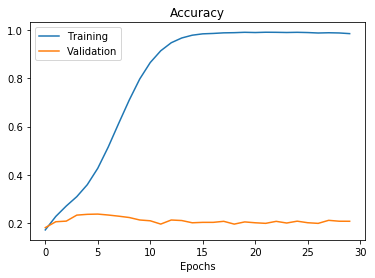

In [12]:
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])

plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

# Evaluation

## Testset 

In [13]:
df = pd.read_csv('xtest_obfuscated.txt', header=None)
df.columns = ['Text']

In [14]:
df['Character vector'] = df['Text'].transform(lambda X: np.array([convert_char_to_num(c) for c in X]))
df.head()

,Text,Character vector
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...,"[19, 21, 11, 4, 19, 22, 6, 25, 10, 17, 16, 21,..."
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...,"[16, 21, 12, 21, 20, 7, 18, 10, 11, 4, 4, 13, ..."
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...,"[19, 22, 0, 12, 20, 7, 20, 11, 4, 13, 0, 12, 2..."
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...,"[18, 14, 14, 0, 19, 22, 16, 21, 21, 8, 19, 22,..."
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...,"[11, 4, 15, 12, 20, 7, 15, 12, 3, 5, 20, 11, 2..."


In [15]:
X_test = np.array(df['Character vector'].values)

print(X_test.shape)

(3000,)


In [16]:
X_test_pad = pad_sequences(X_test, maxlen=maxlen)

print(X_test_pad.shape)

(3000, 150)


In [17]:
X_test_cat = to_categorical(X_test_pad)

print(X_test_cat.shape)

(3000, 150, 26)


In [18]:
X_test_cat = X_test_cat.reshape(-1, maxlen, 26, 1)

print(X_test_cat.shape)

(3000, 150, 26, 1)


## Predict

In [19]:
from keras.models import load_model

model = load_model('CNN.h5')

In [20]:
y_pred = model.predict(X_test_cat)

In [21]:
y_test = [np.argmax(y, axis=None, out=None) for y in y_pred]

In [22]:
with open('ytest.txt', 'w') as outfile:
    for y in y_test:
        outfile.write('{}\n'.format(str(y)))